In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
def sam_to_table(code):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
        
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith('ENSMUST'):
                read_table[line_list[2].split('|')[0]]+=1
            
    table_df = pd.Series(read_table)
    return table_df[table_df>= 30] # 30 read 보다 작은 경우는 filter

In [152]:
table = sam_to_table("RPF_siLin28a")
table.head()

ENSMUST00000240377.1    1007005
ENSMUST00000116560.3       1341
ENSMUST00000209469.2       1377
ENSMUST00000237122.2       1335
ENSMUST00000236645.2       1002
dtype: int64

In [141]:
table = table.sort_values(ascending=False)
table.head()
len(table)

9574

In [119]:
path = "/home/qbio1/kangjunseo/tutorials/ref_gene/gencode.vM29.primary_assembly.annotation.gtf"

In [31]:
def read_specific_transcript(code, trans):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith(trans):
                read_table[int(line_list[3])]+=1
            
    table_df = pd.Series(read_table)
    return table_df

In [114]:
RST = read_specific_transcript("RPF_siLin28a","ENSMUSG00000026131.21")
RST.head()

/tmp/ipykernel_734766/446982360.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_df = pd.Series(read_table)


Series([], dtype: float64)

In [115]:
RST.sort_values(ascending=False).head()

Series([], dtype: float64)

<AxesSubplot:>

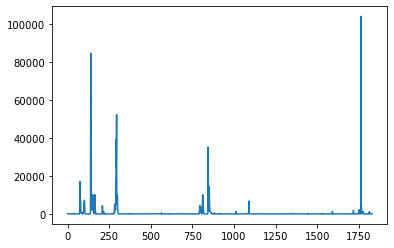

In [53]:
RST = RST.sort_index()
RST.plot()

In [46]:
table2 = sam_to_table("RPF_siLuc")
table2.head()

ENSMUST00000082390.1       25977
ENSMUST00000044200.11        707
ENSMUST00000204185.2         288
ENSMUST00000058030.10        780
ENSMUST00000240377.1     6432837
dtype: int64

In [47]:
table2.sort_values(ascending=False).head()

ENSMUST00000240377.1     6432837
ENSMUST00000082402.1       63193
ENSMUST00000024739.14      62942
ENSMUST00000094361.11      61914
ENSMUST00000021698.13      59815
dtype: int64

In [57]:
RST2 = read_specific_transcript("RPF_siLuc","ENSMUST00000240377.1")
RST2.sort_index().head()

1    2148
2     113
3      56
4      24
5      31
dtype: int64

1848


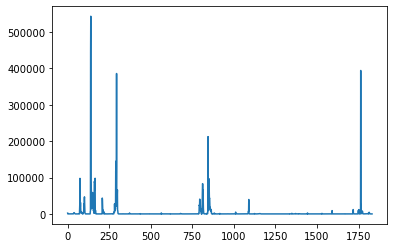

In [56]:
RST2.sort_index()[:].plot()
print(9092-7244)

## 1.GTF File Parsing

### Informations we need
- column 3 : feature type
- column 4 : genomic start loc
- column 5 : genomic end loc
- column 7 : genomic strand(+/-)
- column 9 : additional info
    - gene_id
    - transcript_id
    - gene_type
    - level
    
### Filtering
- non coding genes
- gene level not 1
- (+) strand

In [160]:
def parse_add(add):
    ret_dict = {'transcript_id':''}
    valid = ['gene_id','transcript_id','gene_type','gene_name','level']
    for row in add.split(';'):
        kv_pair = row.split()
        if len(kv_pair)<=1 : continue
        if kv_pair[0] in valid:
            ret_dict[kv_pair[0]]=kv_pair[1]
    return list(ret_dict.values())

In [182]:
GTF_df = pd.read_csv(path, header=5, delimiter='\t')
GTF_df.columns=['chr','ann','feature','start','end','score','strand','phase','add']
GTF_df.head()

,chr,ann,feature,start,end,score,strand,phase,add
0,chr1,HAVANA,transcript,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,chr1,HAVANA,exon,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,chr1,ENSEMBL,gene,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,chr1,ENSEMBL,transcript,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,chr1,ENSEMBL,exon,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [185]:
GTF_df_compact = GTF_df.drop(columns=['chr','ann','score','phase'])
GTF_df_compact.head()

,feature,start,end,strand,add
0,transcript,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,exon,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,gene,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,transcript,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,exon,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [ ]:
import time
start = time.time()

cnt = 0
GTF_df = pd.DataFrame()
path = "/home/qbio1/kangjunseo/tutorials/ref_gene/gencode.vM29.primary_assembly.annotation.gtf"
with open(path) as inpfile:
    for line in inpfile:
        if cnt>=100000: break
        
        if cnt%20000==0 and cnt : 
            print('####'+str(cnt)+'####')
            print("time :", time.time() - start)
        if line.startswith('#'): continue # header 제거
        line_list = line.split('\t')
        parsed_add = parse_add(line_list[8])
        if parsed_add[2] != '"protein_coding"' or parsed_add[4] == '3' : 
            cnt+=1
            continue
        
        line_df = pd.DataFrame(line_list[2:5]+[line_list[6]]+parsed_add).transpose()
        GTF_df = pd.concat([GTF_df,line_df], ignore_index=True)
        cnt+=1

GTF_df.columns = ['feature','start','end','strand','transcript_id','gene_id','gene_type','gene_name','level']
GTF_df.head()

####20000####
time : 0.7919094562530518
####40000####
time : 1.6100544929504395
####60000####
time : 2.418590784072876
####80000####
time : 3.1884045600891113


""


In [165]:
print(len(GTF_df))
GTF_df['start'] = GTF_df['start'].astype('int')
GTF_df['end'] = GTF_df['end'].astype('int')
GTF_df['length'] = GTF_df['end']-GTF_df['start']+1
GTF_df_plus = GTF_df[GTF_df['strand']=='+']
GTF_df_plus.head()

33728


,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
0,gene,6557455,6931164,+,,"""ENSMUSG00000033740.18""","""protein_coding""","""St18""",1,373710
1,transcript,6927565,6929828,+,"""ENSMUST00000130338.2""","""ENSMUSG00000033740.18""","""protein_coding""","""St18""",1,2264
2,exon,6927565,6927667,+,"""ENSMUST00000130338.2""","""ENSMUSG00000033740.18""","""protein_coding""","""St18""",1,103
3,CDS,6927565,6927667,+,"""ENSMUST00000130338.2""","""ENSMUSG00000033740.18""","""protein_coding""","""St18""",1,103
4,exon,6929212,6929828,+,"""ENSMUST00000130338.2""","""ENSMUSG00000033740.18""","""protein_coding""","""St18""",1,617


In [166]:
GTF_df_plus_CDS = GTF_df_plus[GTF_df_plus['feature']=='CDS']
GTF_df_plus_CDS.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
3,CDS,6927565,6927667,+,"""ENSMUST00000130338.2""","""ENSMUSG00000033740.18""","""protein_coding""","""St18""",1,103
5,CDS,6929212,6929391,+,"""ENSMUST00000130338.2""","""ENSMUSG00000033740.18""","""protein_coding""","""St18""",1,180
80,CDS,24717838,24717897,+,"""ENSMUST00000186096.7""","""ENSMUSG00000073725.9""","""protein_coding""","""Lmbrd1""",1,60
83,CDS,24724478,24724654,+,"""ENSMUST00000186096.7""","""ENSMUSG00000073725.9""","""protein_coding""","""Lmbrd1""",1,177
85,CDS,24732022,24732082,+,"""ENSMUST00000186096.7""","""ENSMUSG00000073725.9""","""protein_coding""","""Lmbrd1""",1,61


In [168]:
GTF_df_plus_CDS[['transcript_id','length']].groupby(by=['transcript_id']).sum().sort_values(by=['length'], ascending=False)

,length
transcript_id,
"""ENSMUST00000183034.5""",23151
"""ENSMUST00000143764.9""",20985
"""ENSMUST00000113532.9""",15300
"""ENSMUST00000042740.13""",15102
"""ENSMUST00000042824.13""",14577
...,...
"""ENSMUST00000185130.2""",46
"""ENSMUST00000097855.4""",43
"""ENSMUST00000127955.2""",27


In [169]:
for gene in GTF_df_plus_CDS['transcript_id']:
    if gene in table.index:
        print(gene)
        

In [170]:
print(table.index)

Index(['ENSMUST00000240377.1', 'ENSMUST00000116560.3', 'ENSMUST00000209469.2',
       'ENSMUST00000237122.2', 'ENSMUST00000236645.2', 'ENSMUST00000065243.9',
       'ENSMUST00000161009.7', 'ENSMUST00000077271.9', 'ENSMUST00000187481.2',
       'ENSMUST00000145607.2',
       ...
       'ENSMUST00000096101.6', 'ENSMUST00000015124.15', 'ENSMUST00000192802.2',
       'ENSMUST00000186043.2', 'ENSMUST00000205355.2', 'ENSMUST00000205321.2',
       'ENSMUST00000228970.2', 'ENSMUST00000203416.2', 'ENSMUST00000126256.2',
       'ENSMUST00000169308.8'],
      dtype='object', length=20000)
